In [4]:
pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

data = pd.read_csv("/Users/bnj/Desktop/백남진/project/data/공모주_데이터.csv")

##################################################################
data['공모가_원']=data['공모가_원'].str.strip()
data['공모금액_백만원']=data['공모금액_백만원'].str.strip()
data['기관경쟁률']=data['기관경쟁률'].str.strip()
data['의무보유확약_퍼센트']=data['의무보유확약_퍼센트'].str.strip()
data['시초가']=data['시초가'].str.strip()

data['하한가']=data['공모희망가_원'].str.split('~',expand=True)[0]
data['상한가']=data['공모희망가_원'].str.split('~',expand=True)[1]
data['의무보유확약_퍼센트']=data['의무보유확약_퍼센트'].str.split('%',expand=True)[0]
data['기관경쟁률']=data['기관경쟁률'].str.split(':',expand=True)[0]

data['공모가_원']=data['공모가_원'].apply(lambda x: x.replace(',',''))
data['하한가']=data['하한가'].apply(lambda x: x.replace(',',''))
data['상한가']=data['상한가'].apply(lambda x: x.replace(',',''))
data['시초가']=data['시초가'].apply(lambda x: x.replace(',',''))
data['공모금액_백만원']=data['공모금액_백만원'].apply(lambda x: x.replace(',',''))
data['기관경쟁률']=data['기관경쟁률'].apply(lambda x: x.replace(',','') if type(x) != float else x)

##################################################################
#이베스트스팩5호
data.loc[245,'공모금액_백만원']= "7000"
data.loc[245,'의무보유확약_퍼센트']= 0

#신영스팩6호
data.loc[255,'공모금액_백만원']= "8400"
data.loc[255,'의무보유확약_퍼센트']= 0

#아이티엠반도체
data.loc[289,'공모금액_백만원']= "131300"
data.loc[289,'의무보유확약_퍼센트']= 0

#의무보유확약 replace
data['의무보유확약_퍼센트']=data['의무보유확약_퍼센트'].replace('-',0)

#기관경쟁률 0으로 채우기
data['기관경쟁률'].fillna(0,inplace=True)

data['공모가_원']=data['공모가_원'].astype('int')
data['공모금액_백만원']=data['공모금액_백만원'].astype('int')
data['기관경쟁률']=data['기관경쟁률'].astype('float')
data['의무보유확약_퍼센트']=data['의무보유확약_퍼센트'].astype('float')
data['시초가']=data['시초가'].astype('int')
data['하한가']=data['하한가'].astype('int')
data['상한가']=data['상한가'].astype('int')

data.drop(['예측일','공모희망가_원','주간사'],1,inplace=True)
##################################################################
financial_statements = pd.read_csv("/Users/bnj/Desktop/백남진/project/data/공모주_재무제표.csv")
financial_statements.columns = ['종목명', '회사명종목코드', '상장일', '결산년도', '결산월', '업종', '자산', '부채', '자본',
       '매출액(수익)', '매출액(수익)증감률', '영업이익', '영업이익(증감률)', '당기순이익', '당기순이익(증감률)']
financial_statements = financial_statements.drop(['회사명종목코드','업종','매출액(수익)증감률','영업이익(증감률)','당기순이익(증감률)','상장일','결산월','결산년도'],1)

df = data.merge(financial_statements)
df.fillna(0,inplace=True)

train = df[13:]
test = df[:13]
target= test['시초가']
test.drop(['시초가'],1,inplace=True)

##################################################################
from feature_engine.outliers import OutlierTrimmer

trimmer = OutlierTrimmer(capping_method='iqr')
train = trimmer.fit_transform(train)

##################################################################
train['스팩유무']=train['종목명'].apply(lambda x: 1 if x.find('스팩')>=0 else 0)
test['스팩유무']=test['종목명'].apply(lambda x: 1 if x.find('스팩')>=0 else 0)

train['부채비율']=train['부채']/train['자산']
test['부채비율']=test['부채']/test['자산']

train['자기자본비율']= train['자본']/train['자산']
test['자기자본비율']= test['자본']/test['자산']

train = train.drop(['종목명','부채'],1)
test = test.drop(['종목명','부채'],1)

,공모가_원,공모금액_백만원,기관경쟁률,의무보유확약_퍼센트,시초가,하한가,상한가,자산,자본,매출액(수익),영업이익,당기순이익,스팩유무,부채비율,자기자본비율
13,10000,19500,31.5000,0.0000,9670,13000,17000,19943843,1857094,1475309,-11423071,-12315478,0,0.9069,0.0931
14,15000,15000,190.5900,19.9300,17400,15000,19500,58162569,32958265,48096362,7554590,6412164,0,0.4333,0.5667
15,15200,39600,1556.5300,11.0000,20200,13200,15200,65919054,28563627,39431184,3064765,2844609,0,0.5667,0.4333
16,8000,40500,20.0600,0.0000,7200,9000,10500,80896613,63920155,42411460,27485737,22377888,0,0.2099,0.7901
17,15000,18240,1535.4200,11.0800,30000,11400,13700,17611623,12784209,22171956,1219720,2641796,0,0.2741,0.7259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,27000,19872,1124.0500,13.1400,34750,23000,27000,46060604,43481855,14179406,2954755,3248885,0,0.0560,0.9440
208,12500,13820,1082.1500,18.1800,22800,10000,12500,58205550,36000821,36106051,-1265541,-295846,0,0.3815,0.6185
209,14300,21692,614.2500,3.5600,12900,11600,14300,97505089,47553049,58737698,6761389,16878968,0,0.5123,0.4877
210,26000,27996,1133.0000,22.0000,31600,19000,23000,28424144,17084383,9711357,-4636376,-4255396,0,0.3989,0.6011


In [5]:
from pycaret.regression import *

setup(data=train, target='시초가', fold_shuffle=True, session_id=123,verbose=False,normalize=True,normalize_method='robust')

Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
공모가_원,Numeric
공모금액_백만원,Numeric
기관경쟁률,Numeric
의무보유확약_퍼센트,Numeric
하한가,Numeric
상한가,Numeric
자산,Numeric
자본,Numeric
매출액(수익),Numeric
영업이익,Numeric


AttributeError: 'Simple_Imputer' object has no attribute 'fill_value_categorical'

In [6]:
models = compare_models(n_select=4,sort='RMSLE',fold=10,cross_validation=True)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,4782.1433,48769188.3554,6466.1391,0.7879,0.2405,0.2122,0.0440
gbr,Gradient Boosting Regressor,4515.5072,46195093.3300,6272.1251,0.7615,0.2554,0.2115,0.0120
et,Extra Trees Regressor,4922.9515,52094097.6973,6790.4877,0.7580,0.2569,0.2176,0.0430
xgboost,Extreme Gradient Boosting,5286.3678,69212007.0000,7587.5097,0.6826,0.2751,0.2240,0.3170
catboost,CatBoost Regressor,5161.1115,59065957.6602,7208.0081,0.7233,0.2934,0.2461,0.2710
omp,Orthogonal Matching Pursuit,6815.1484,75702457.1095,8520.6764,0.6188,0.3021,0.2887,0.0030
dt,Decision Tree Regressor,5174.9487,61222711.9231,7519.1200,0.6344,0.3186,0.2465,0.0030
en,Elastic Net,6469.5210,84186683.4000,8663.5462,0.6593,0.3320,0.3126,0.0030
ada,AdaBoost Regressor,5650.3693,66251926.8580,7299.6981,0.7311,0.3349,0.3131,0.0140
par,Passive Aggressive Regressor,5800.1239,76113647.3019,8251.6059,0.6926,0.3415,0.3798,0.0040


In [7]:
blended_models = blend_models(models,choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3117.9786,14714277.2929,3835.9194,0.9624,0.1172,0.1010
1,2328.5821,9113922.6031,3018.9274,0.9630,0.2528,0.1968
2,5786.1999,121911173.9373,11041.3393,0.5994,0.3192,0.2353
3,4543.3346,30138269.2412,5489.8333,0.6645,0.2191,0.1763
4,5380.6445,47264974.6532,6874.9527,0.8642,0.2776,0.2285
5,7211.6914,110481273.8950,10511.0073,0.7708,0.3214,0.2917
6,3508.5308,23858035.4244,4884.4688,0.7735,0.1831,0.1591
7,7182.4789,91217570.6763,9550.7890,0.8111,0.2753,0.2674
8,3682.5116,19680811.7370,4436.3061,0.8415,0.1769,0.1671
9,4126.4797,24589588.7849,4958.7890,0.4761,0.2635,0.2480


In [8]:
final_model=finalize_model(blended_models,)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)
/opt

In [9]:
prediction = predict_model(estimator=final_model,data=test)

In [10]:
final_df = pd.DataFrame(prediction['Label']).join(target)

In [11]:
final_df.columns=['예측값','실제값']

In [12]:
final_df

,예측값,실제값
0,8031.6500,6500
1,26483.5000,24150
2,16652.5000,15450
3,28857.0000,34000
4,2775.8000,2295
5,2748.7000,2270
6,27764.0000,32800
7,2767.5000,2115
8,8788.2000,8800
9,20416.5000,21600


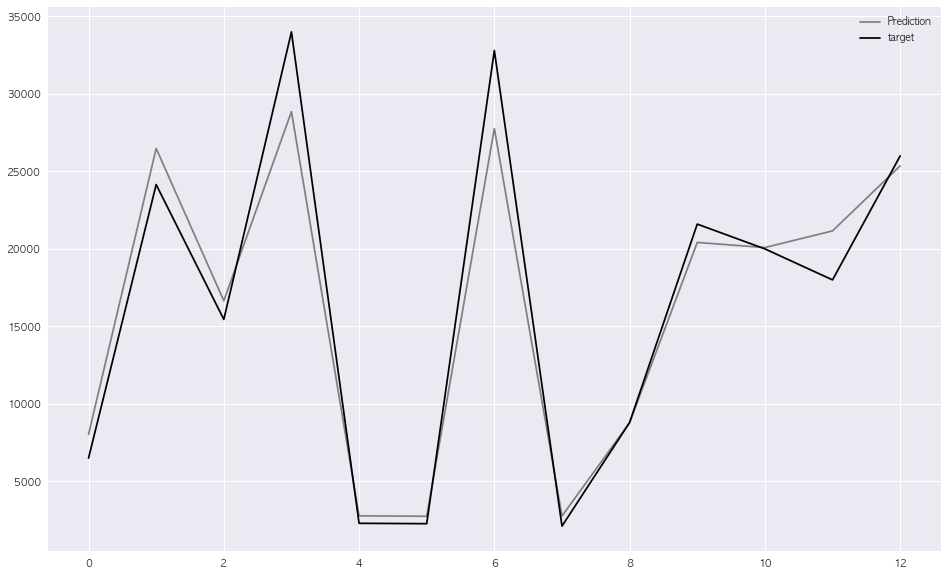

In [13]:
f,ax = plt.subplots(1,1,figsize=(16,10))
plt.plot(final_df['예측값'],color='gray')
plt.plot(final_df['실제값'],color='black')
plt.legend(['Prediction','target'])

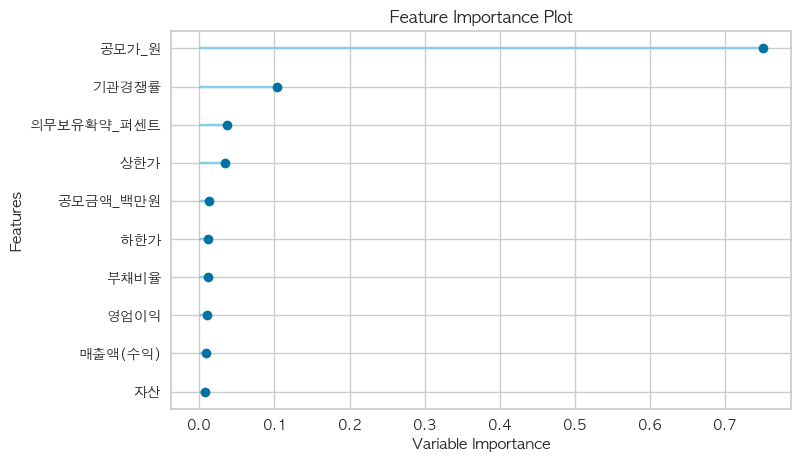

In [18]:
# import matplotlib.pyplot as plt
# from matplotlib import rc
# import seaborn as sns
# %matplotlib inline
# rc('font', family='AppleGothic')
# plt.rcParams['axes.unicode_minus'] = False
plot_model(final_model,plot='feature')

범한퓨얼셀은?

In [15]:
new_data= pd.read_excel("/Users/bnj/Desktop/범한퓨얼셀.xls")
new_data['부채비율']=new_data['부채']/new_data['자산']
new_data['자기자본비율']= new_data['자본']/new_data['자산']
new_data.drop(['부채'],1,inplace=True)

# 범한퓨얼셀 예측

In [16]:
predict_model(final_model,new_data)['Label']

0   48100.5000
Name: Label, dtype: float64